# Exploratory Data Analysis
Exploratory data analysis for the [UCI dataset](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008). The dataset represents ten years (1999-2008) of clinical care at 130 US hospitals and integrated delivery networks.

Each row concerns hospital records of patients diagnosed with diabetes, who underwent laboratory, medications, and stayed up to 14 days. The goal is to determine the **early readmission of the patient within 30 days of discharge**.

The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for diabetic patients who receive various preventive and therapeutic interventions, many patients do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals (as the patients are readmitted) but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

## **0. Initial Setup**
Taking care of package imports, defining work constants, and loading all necessary datasets.

### 0.1 Python imports

In [57]:
# Data Analysis
import pandas as pd
import numpy as np
import random as rnd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

### 0.2 Constants

In [58]:
DATA_PATH = '../data/'

RANDOM_STATE = 38

### 0.3 Loading datasets

In [59]:
diabetic_data = pd.read_csv(
    DATA_PATH + 'diabetic_data.csv',
    index_col='encounter_id',
    na_values='?',
    keep_default_na=False
)

/tmp/ipykernel_9305/3483556448.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  diabetic_data = pd.read_csv(


## **1. Data Understanding**
Exploring the nature of the dataset.

- Database shape (entries and features)
- Database head and tail
- Feature types (dtypes)
- Feature distribution (describe)

In [60]:
diabetic_data.head()

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,...,No,No,No,No,No,No,No,No,Yes,NO
500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,...,No,Up,No,No,No,No,No,Ch,Yes,NO
16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [61]:
diabetic_data.tail()

,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
443847548,100162476,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,...,No,Down,No,No,No,No,No,Ch,Yes,>30
443847782,74694222,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,...,No,Steady,No,No,No,No,No,No,Yes,NO
443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,...,No,Down,No,No,No,No,No,Ch,Yes,NO
443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,...,No,Up,No,No,No,No,No,Ch,Yes,NO
443867222,175429310,Caucasian,Male,[70-80),NaN,1,1,7,6,NaN,...,No,No,No,No,No,No,No,No,No,NO


Checking columns dtypes

In [63]:
diabetic_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101766 entries, 2278392 to 443867222
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   patient_nbr               101766 non-null  int64 
 1   race                      99493 non-null   object
 2   gender                    101766 non-null  object
 3   age                       101766 non-null  object
 4   weight                    3197 non-null    object
 5   admission_type_id         101766 non-null  int64 
 6   discharge_disposition_id  101766 non-null  int64 
 7   admission_source_id       101766 non-null  int64 
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                61510 non-null   object
 10  medical_specialty         51817 non-null   object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  

In [64]:
diabetic_data.isnull().sum().sort_values(ascending=False)

weight                      98569
medical_specialty           49949
payer_code                  40256
race                         2273
diag_3                       1423
diag_2                        358
diag_1                         21
admission_type_id               0
patient_nbr                     0
time_in_hospital                0
admission_source_id             0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
discharge_disposition_id        0
gender                          0
age                             0
number_inpatient                0
number_emergency                0
number_outpatient               0
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide     

Since we are primarily interested in factors that lead to early readmission, we defined the readmission attribute (outcome) as having two values: `readmitted`, if the patient was readmitted within 30 days of discharge or `otherwise`, which covers both readmission after 30 days and no readmission at all.

In [65]:
# diabetic_data['readmitted'] = diabetic_data['readmitted'].replace(
#     {
#         '<30': 'readmitted',
#         'NO': 'otherwise',
#         '>30': 'otherwise'
#     }
# )

## **2. Graphs**
Work in progress... the estimated date of completion is also work in progress LoL

### 2.1 Univariate

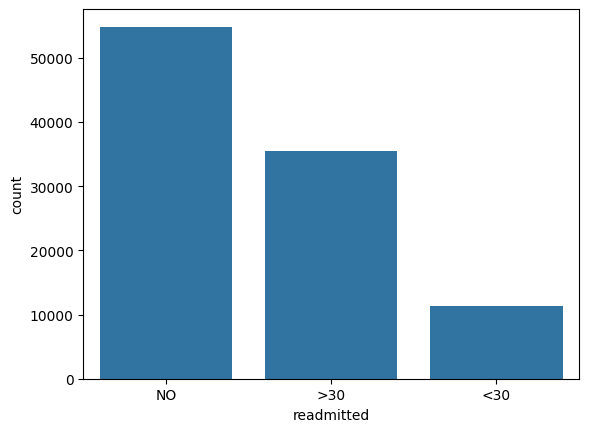

In [71]:
sns.countplot(data=diabetic_data, x='readmitted')
plt.show()

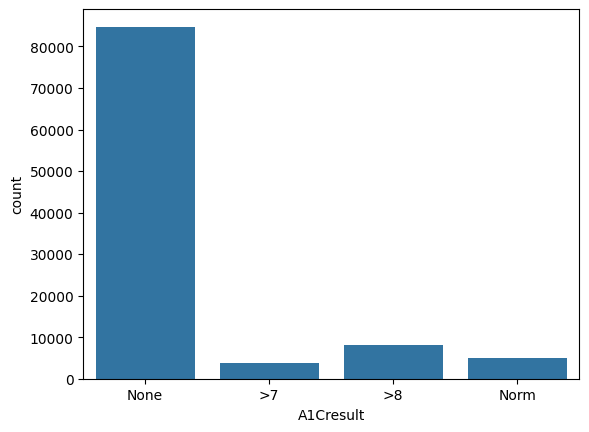

In [72]:
sns.countplot(data=diabetic_data, x='A1Cresult')
plt.show()

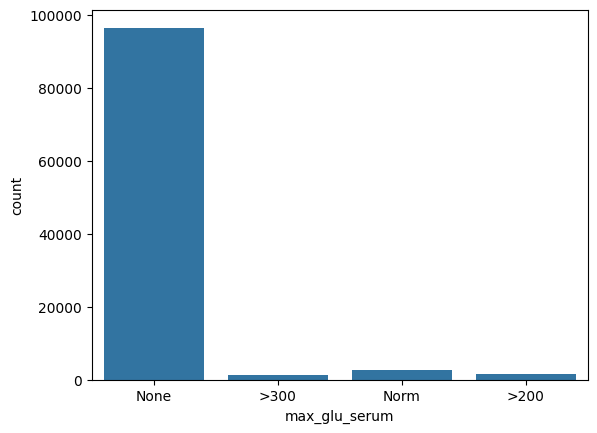

In [73]:
sns.countplot(data=diabetic_data, x='max_glu_serum')
plt.show()

### 2.2 Multivariate

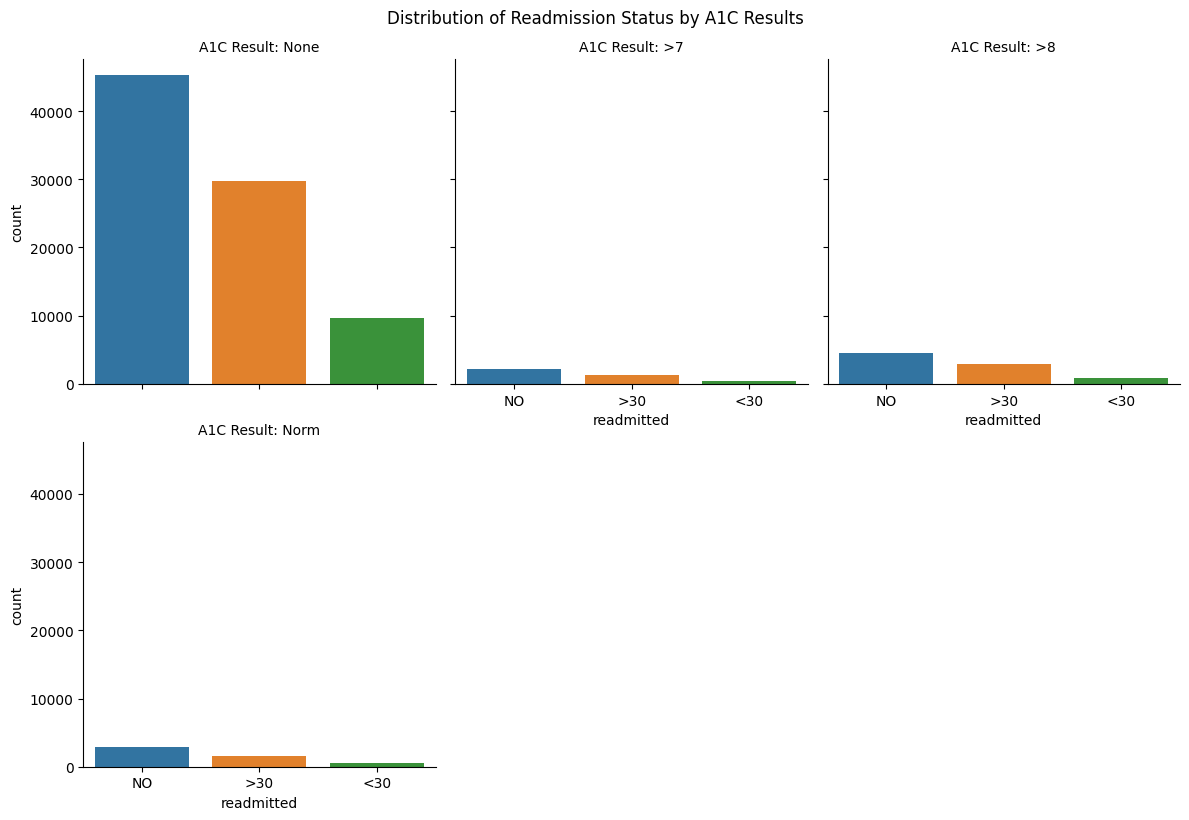

In [66]:
g = sns.catplot(data=diabetic_data, x='readmitted', col='A1Cresult', hue='readmitted', kind='count', col_wrap=3, height=4)

# Add title and improve spacing
g.fig.suptitle('Distribution of Readmission Status by A1C Results', y=1.02)
g.set_titles('A1C Result: {col_name}')

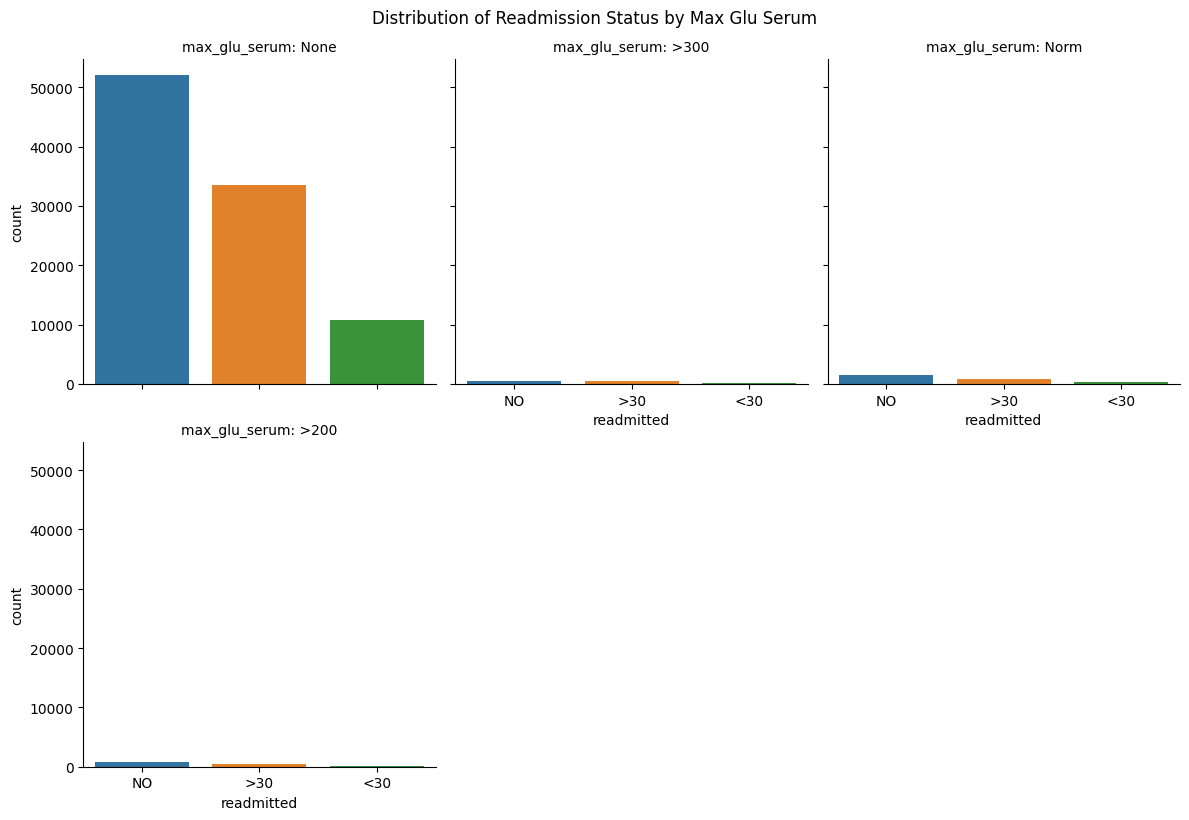

In [70]:
g = sns.catplot(data=diabetic_data, x='readmitted', col='max_glu_serum', hue='readmitted', kind='count', col_wrap=3, height=4)

# Add title and improve spacing
g.fig.suptitle('Distribution of Readmission Status by Max Glu Serum', y=1.02)
g.set_titles('max_glu_serum: {col_name}')

#### A1Cresult
For **A1Cresult**, there doesn't seem to be any direct visible relationship with the readmissions.

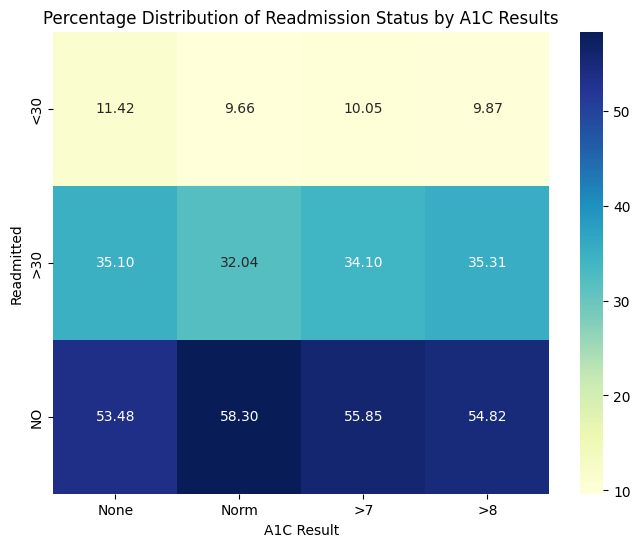

In [82]:
# Create the crosstab with the specific column order
crosstab = pd.crosstab(
    diabetic_data['readmitted'],
    diabetic_data['A1Cresult']
)

# Reorder the columns to match the desired order
crosstab = crosstab.reindex(columns=['None', 'Norm', '>7', '>8'])

# Normalize the crosstab to get column-wise percentages
crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Plot the heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab_percent, annot=True, cmap="YlGnBu", fmt=".2f")

# Add labels and title
plt.title('Percentage Distribution of Readmission Status by A1C Results')
plt.xlabel('A1C Result')
plt.ylabel('Readmitted')

plt.show()

#### Max Glucose Serum
For **max_glu_serum**, there is a visible direct correlation with readmission rates. For people that were readmitted within 30 days, but also for those readmitted after 30 days, readmission rates increase with the increase of glucose.

For all those people that were not readmitted, there is an inverse relationship with the increase of glucose levels.

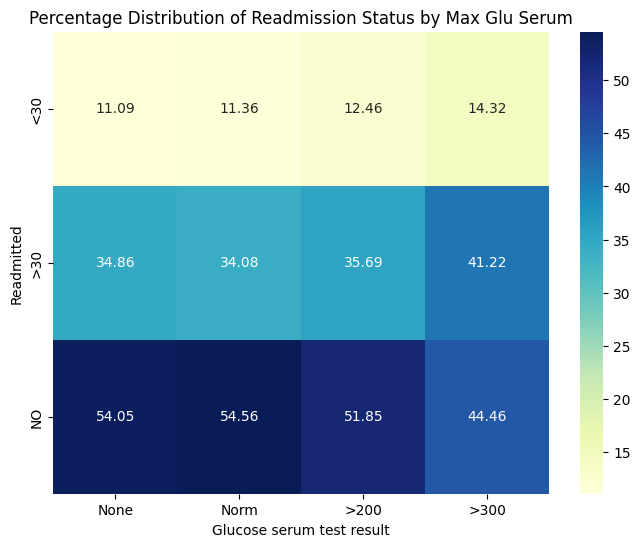

In [84]:
# Create the crosstab with the specific column order
crosstab = pd.crosstab(
    diabetic_data['readmitted'],
    diabetic_data['max_glu_serum']
)

# Reorder the columns to match the desired order
crosstab = crosstab.reindex(columns=['None', 'Norm', '>200', '>300'])

# Normalize the crosstab to get column-wise percentages
crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Plot the heatmap with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(crosstab_percent, annot=True, cmap="YlGnBu", fmt=".2f")

# Add labels and title
plt.title('Percentage Distribution of Readmission Status by Max Glu Serum')
plt.xlabel('Glucose serum test result')
plt.ylabel('Readmitted')

plt.show()

#### Age
For **age**, there is a very slight correlation with readmission rates. Percentage of readmitted people, both for <30 and >30, is directly proportional up to 20 years. After the 20s, we notice an attenuation of values, meaning that the readmission percentage does not increase as the age increases, but remains stable.

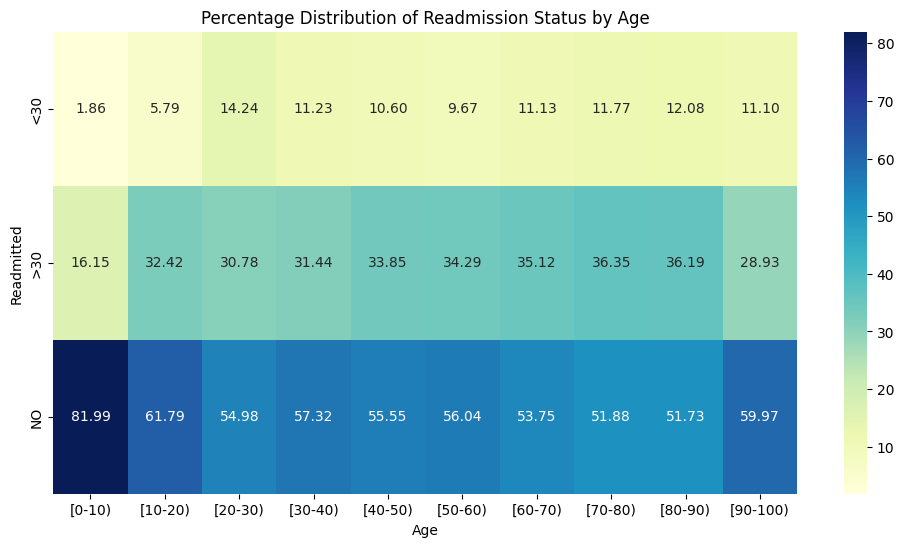

In [87]:
# Create the crosstab with the specific column order
crosstab = pd.crosstab(
    diabetic_data['readmitted'],
    diabetic_data['age']
)

# Reorder the columns to match the desired order
crosstab = crosstab.reindex(columns=[
    '[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)',
    '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)'
])

# Normalize the crosstab to get column-wise percentages
crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Plot the heatmap with percentages
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab_percent, annot=True, cmap="YlGnBu", fmt=".2f")

# Add labels and title
plt.title('Percentage Distribution of Readmission Status by Age')
plt.xlabel('Age')
plt.ylabel('Readmitted')

plt.show()

#### Impatient visits
For **number_inpatient**, positive correlation is immediately noticeable.

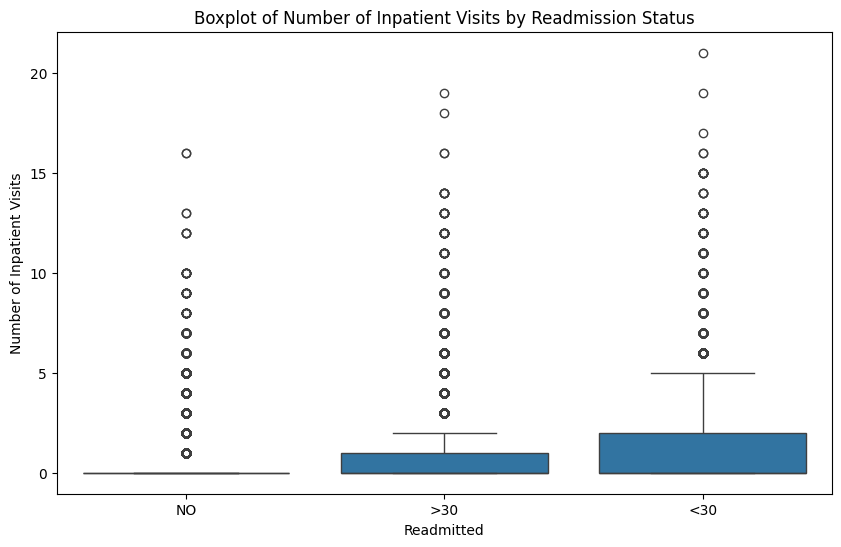

In [89]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='number_inpatient')

# Add labels and title
plt.title('Boxplot of Number of Inpatient Visits by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Inpatient Visits')

# Show the plot
plt.show()

#### Outpatient visits
For **number_outpatient**, ...

**RETRY AFTER HANDLING OUTLIER VALUES**

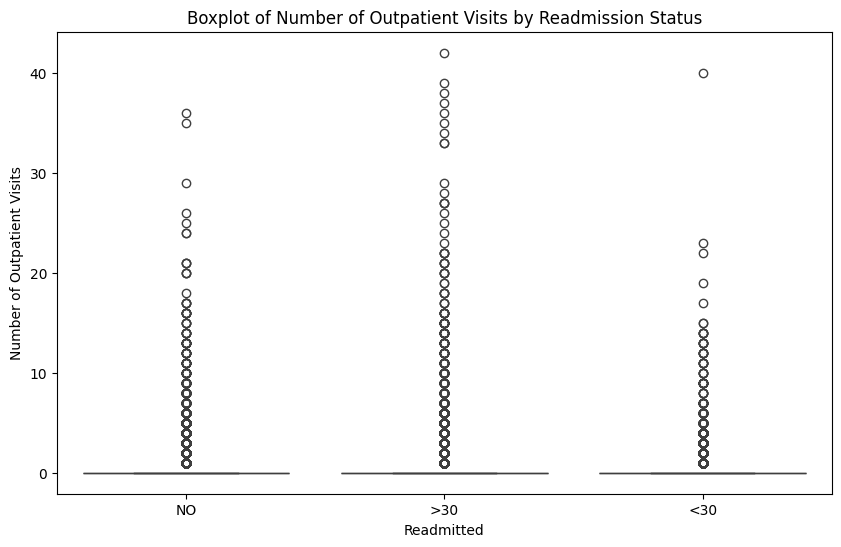

In [91]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='number_outpatient')

# Add labels and title
plt.title('Boxplot of Number of Outpatient Visits by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Outpatient Visits')

# Show the plot
plt.show()

#### Emergency visits
For **number_emergency**...

**RETRY AFTER HANDLING OUTLIER VALUES**

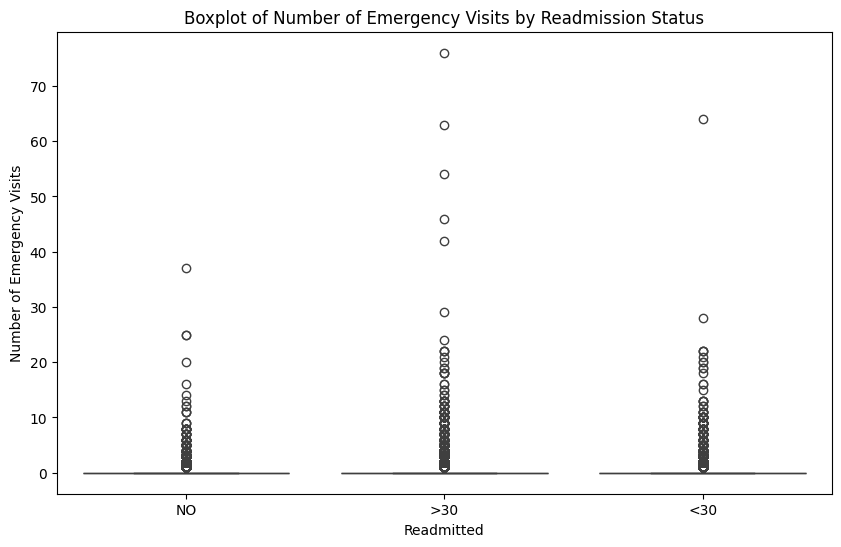

In [90]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(data=diabetic_data, x='readmitted', y='number_emergency')

# Add labels and title
plt.title('Boxplot of Number of Emergency Visits by Readmission Status')
plt.xlabel('Readmitted')
plt.ylabel('Number of Emergency Visits')

# Show the plot
plt.show()

#### Insulin (CONTROLLARE NEL DATASET ESISTENZA MEDICAZIONI)
For **insulin**, if you leave unmodified, everything is fine... if you change the dosage, shit hits the fan.

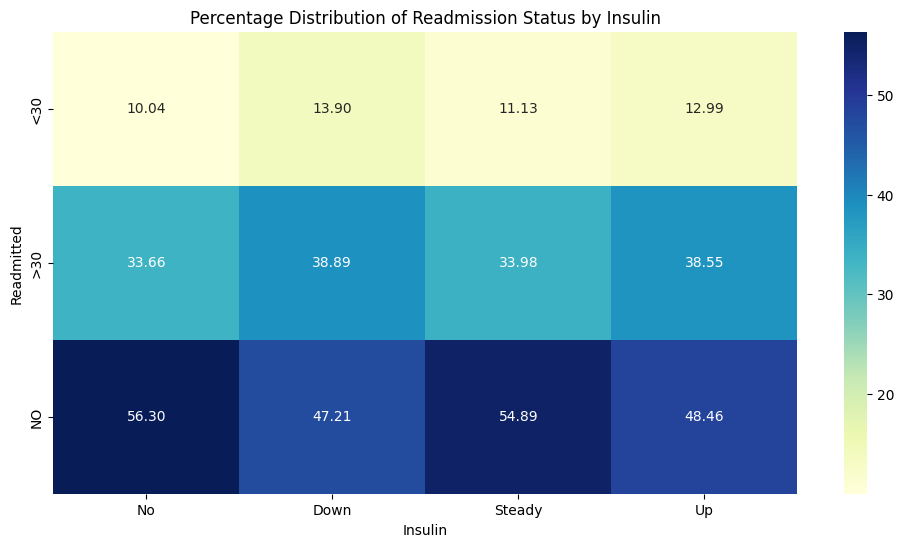

In [93]:
# Create the crosstab with the specific column order
crosstab = pd.crosstab(
    diabetic_data['readmitted'],
    diabetic_data['insulin']
)

# Reorder the columns to match the desired order
crosstab = crosstab.reindex(columns=[
    'No', 'Down', 'Steady', 'Up'
])

# Normalize the crosstab to get column-wise percentages
crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Plot the heatmap with percentages
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab_percent, annot=True, cmap="YlGnBu", fmt=".2f")

# Add labels and title
plt.title('Percentage Distribution of Readmission Status by Insulin')
plt.xlabel('Insulin')
plt.ylabel('Readmitted')

plt.show()

#### Sulfonylureas (TEMPORARY)

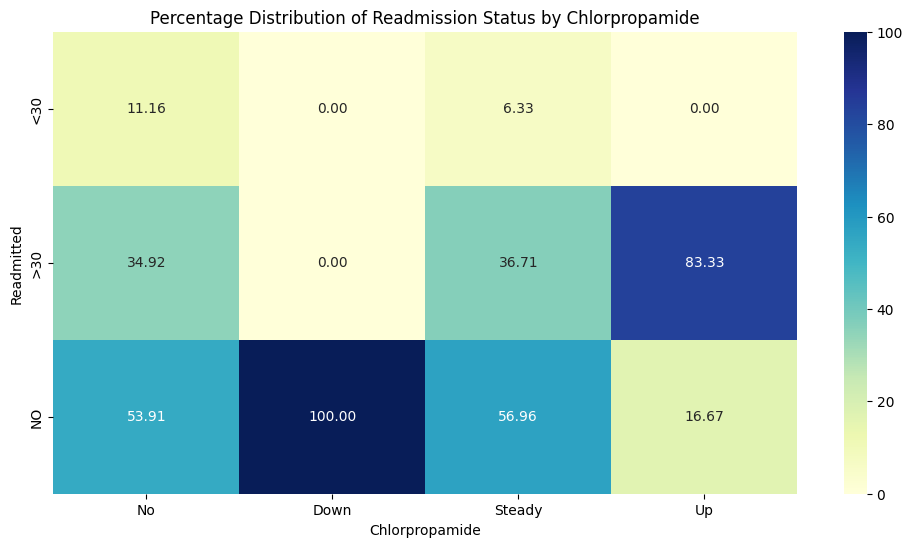

In [97]:
# Create the crosstab with the specific column order
crosstab = pd.crosstab(
    diabetic_data['readmitted'],
    diabetic_data['chlorpropamide']
)

# Reorder the columns to match the desired order
crosstab = crosstab.reindex(columns=[
    'No', 'Down', 'Steady', 'Up'
])

# Normalize the crosstab to get column-wise percentages
crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Plot the heatmap with percentages
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab_percent, annot=True, cmap="YlGnBu", fmt=".2f")

# Add labels and title
plt.title('Percentage Distribution of Readmission Status by Chlorpropamide')
plt.xlabel('Chlorpropamide')
plt.ylabel('Readmitted')

plt.show()

#### TZDs (TEMPORARY)

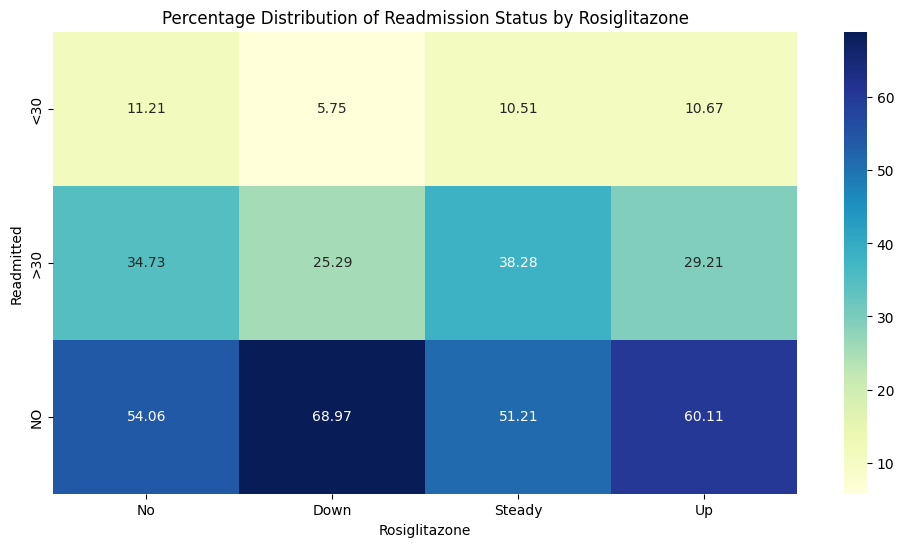

In [98]:
# Create the crosstab with the specific column order
crosstab = pd.crosstab(
    diabetic_data['readmitted'],
    diabetic_data['rosiglitazone']
)

# Reorder the columns to match the desired order
crosstab = crosstab.reindex(columns=[
    'No', 'Down', 'Steady', 'Up'
])

# Normalize the crosstab to get column-wise percentages
crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Plot the heatmap with percentages
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab_percent, annot=True, cmap="YlGnBu", fmt=".2f")

# Add labels and title
plt.title('Percentage Distribution of Readmission Status by Rosiglitazone')
plt.xlabel('Rosiglitazone')
plt.ylabel('Readmitted')

plt.show()

#### Combination Medications (TEMPORARY)

- Decreased Dosage: There is a strong association between a decreased dosage of glyburide-metformin and not being readmitted. The absence of dosage decrease is notably associated with a higher rate of readmission, particularly within 30 days.
- Steady Dosage: Patients with a steady dosage have a varied risk of readmission. Steady dosages are more common among those not readmitted but less so among those readmitted within 30 days.
- Increased Dosage: An increased dosage is very rare, particularly among those readmitted within 30 days, suggesting that increased dosage might be less common or less effective in preventing early readmission.

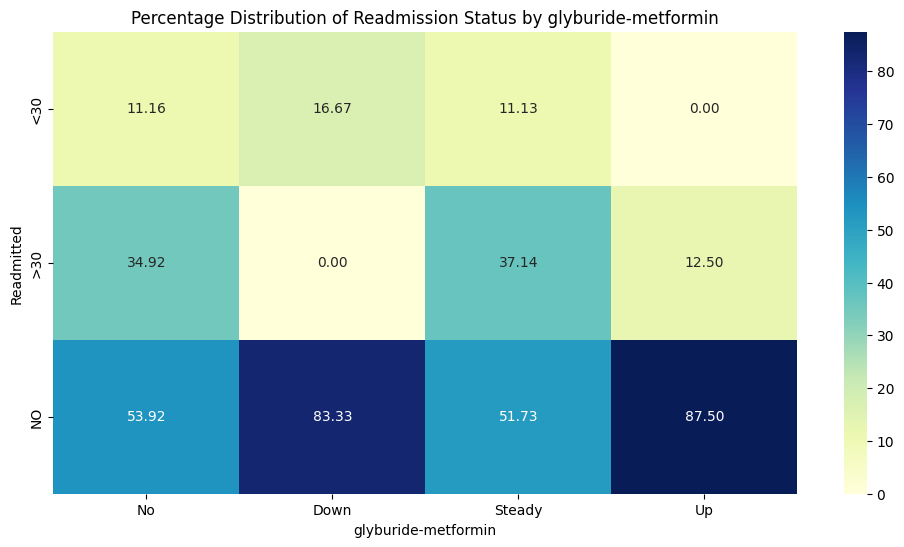

In [94]:
# Create the crosstab with the specific column order
crosstab = pd.crosstab(
    diabetic_data['readmitted'],
    diabetic_data['glyburide-metformin']
)

# Reorder the columns to match the desired order
crosstab = crosstab.reindex(columns=[
    'No', 'Down', 'Steady', 'Up'
])

# Normalize the crosstab to get column-wise percentages
crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Plot the heatmap with percentages
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab_percent, annot=True, cmap="YlGnBu", fmt=".2f")

# Add labels and title
plt.title('Percentage Distribution of Readmission Status by glyburide-metformin')
plt.xlabel('glyburide-metformin')
plt.ylabel('Readmitted')

plt.show()

#### Metformin
For **metmorfin**, no correlation whatsover...

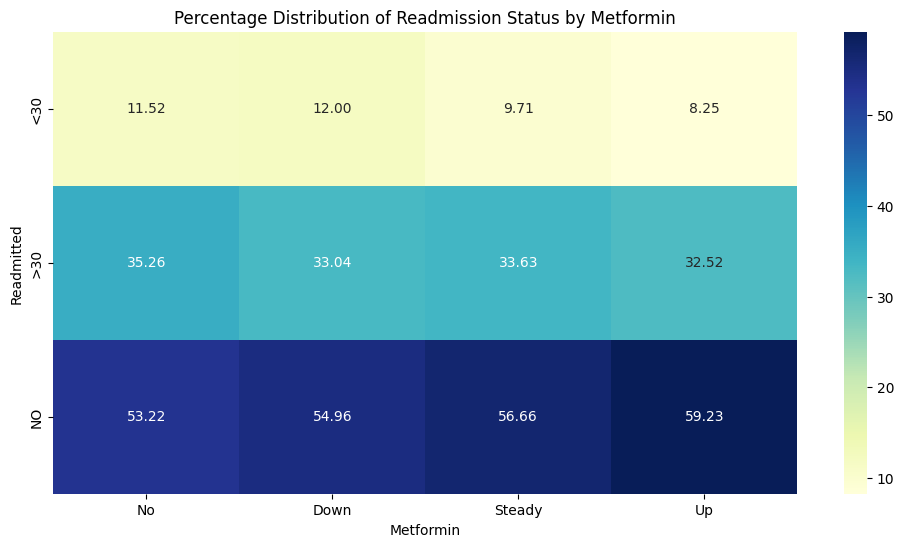

In [99]:
# Create the crosstab with the specific column order
crosstab = pd.crosstab(
    diabetic_data['readmitted'],
    diabetic_data['metformin']
)

# Reorder the columns to match the desired order
crosstab = crosstab.reindex(columns=[
    'No', 'Down', 'Steady', 'Up'
])

# Normalize the crosstab to get column-wise percentages
crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Plot the heatmap with percentages
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab_percent, annot=True, cmap="YlGnBu", fmt=".2f")

# Add labels and title
plt.title('Percentage Distribution of Readmission Status by Metformin')
plt.xlabel('Metformin')
plt.ylabel('Readmitted')

plt.show()

#### Troglitazone
For **troglitazone**, do not give it.

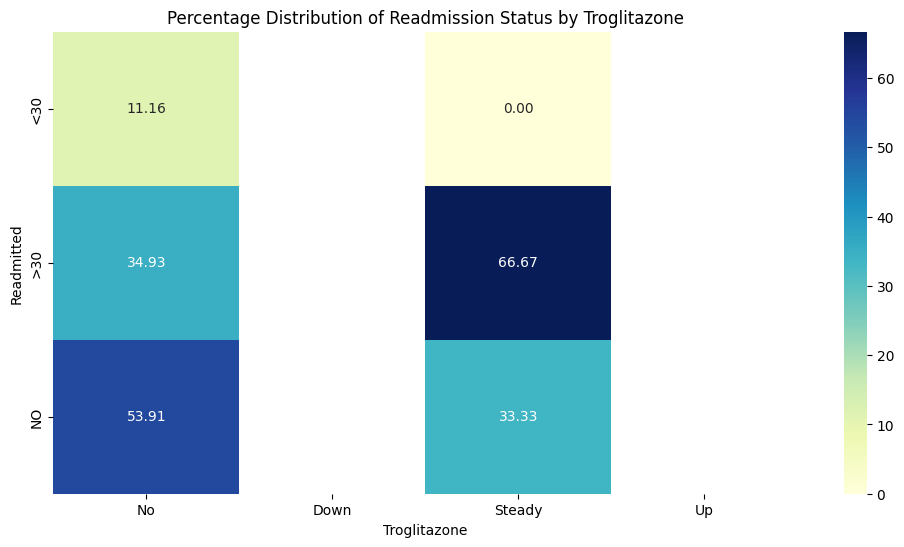

In [101]:
# Create the crosstab with the specific column order
crosstab = pd.crosstab(
    diabetic_data['readmitted'],
    diabetic_data['troglitazone']
)

# Reorder the columns to match the desired order
crosstab = crosstab.reindex(columns=[
    'No', 'Down', 'Steady', 'Up'
])

# Normalize the crosstab to get column-wise percentages
crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Plot the heatmap with percentages
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab_percent, annot=True, cmap="YlGnBu", fmt=".2f")

# Add labels and title
plt.title('Percentage Distribution of Readmission Status by Troglitazone')
plt.xlabel('Troglitazone')
plt.ylabel('Readmitted')

plt.show()

#### Nateglinide
For **nateglinide**, no real correlation visible.

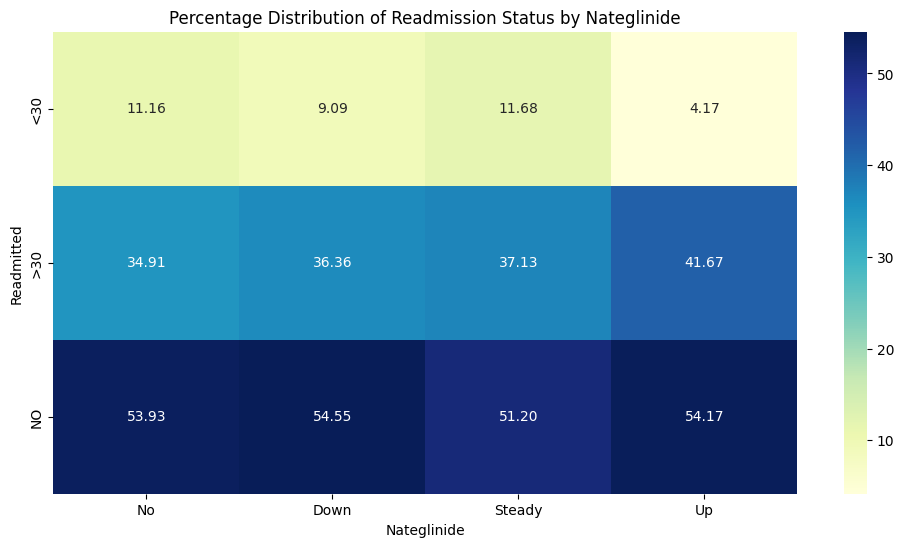

In [102]:
# Create the crosstab with the specific column order
crosstab = pd.crosstab(
    diabetic_data['readmitted'],
    diabetic_data['nateglinide']
)

# Reorder the columns to match the desired order
crosstab = crosstab.reindex(columns=[
    'No', 'Down', 'Steady', 'Up'
])

# Normalize the crosstab to get column-wise percentages
crosstab_percent = crosstab.div(crosstab.sum(axis=0), axis=1) * 100

# Plot the heatmap with percentages
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab_percent, annot=True, cmap="YlGnBu", fmt=".2f")

# Add labels and title
plt.title('Percentage Distribution of Readmission Status by Nateglinide')
plt.xlabel('Nateglinide')
plt.ylabel('Readmitted')

plt.show()